In [1]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import sys
import importlib
import random 
import pandas as pd
pd.options.mode.copy_on_write = True
import time
from os.path import join as pjoin
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 

In [2]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)

/home/ubuntu/Data/joanna-venvs/wave-u-net2/lib/python3.8/site-packages/pysepm/qualityMeasures.py:121: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lpcoeff(speech_frame, model_order):
/home/ubuntu/Data/joanna-venvs/wave-u-net2/lib/python3.8/site-packages/pysepm/qualityMeasures.py:209: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def find_loc_peaks(slope,ene

<module 'models' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/models.py'>

In [3]:
################## LOAD TRAINING RESULTS AND CONFIG  ##################

datapath="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/"
exp_tag="runs-exp-20-05-2024"
train_tag="10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2"

config ,train_results = trainer.load_train_results(datapath, exp_tag, train_tag,configtype="yaml")


/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/trainer.py:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_results=torch.load(pjoin(datapath,exp_tag,tr

In [4]:
################## LOAD DATASET ##################

# instantiate a test data set 
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/17-05-2024--15-42_data_set.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)

In [5]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################

model=trainer.load_chosen_model(config,config["modeltype"])
model.load_state_dict(train_results["model_state_dict"])


<All keys matched successfully>

In [6]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC RT60 VALUES   ##################

# choose indices from a data set with specified difference
chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(-2,-0.85)
# chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(0.8,2)
len(chosen_rt60_idx_list)

45

In [7]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

dp=chosen_rt60_idx_list[random.randint(0, len(chosen_rt60_idx_list) - 1)]
sContent,sStyle,sTarget,sPrediction=trainer.infer(model,dataset[dp],config["device"])
if bool(config["is_vae"]):
    sPrediction, _, _ = sPrediction

In [178]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,id="style")
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model.conditioning_network(sStyle_in.unsqueeze(0).to(config["device"]))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==3000:
        break


    

In [8]:
np.save('emb_arr3.npy', emb_arr)
np.save('rt30_meas_arr3.npy', rt30_meas_arr)
np.save('rt60_set_arr3.npy', rt60_set_arr)
np.save('rt60_true_arr3.npy', rt60_true_arr)
np.save('edt_meas_arr3.npy', edt_meas_arr)
np.save('c50_meas_arr3.npy', c50_meas_arr)

NameError: name 'emb_arr' is not defined

In [9]:
# Read the saved arrays
emb_arr = np.load('emb_arr3.npy')
rt30_meas_arr = np.load('rt30_meas_arr3.npy')
rt60_set_arr = np.load('rt60_set_arr3.npy')
rt60_true_arr = np.load('rt60_true_arr3.npy')
edt_meas_arr = np.load('edt_meas_arr3.npy')
c50_meas_arr = np.load('c50_meas_arr3.npy')

In [10]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
# embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=100).fit_transform(PCA(n_components=20).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=100).fit_transform(emb_arr[indices_subset,:])
# using u-map:
embeddings_umap = umap.UMAP(n_components=2).fit_transform(emb_arr[indices_subset, :])


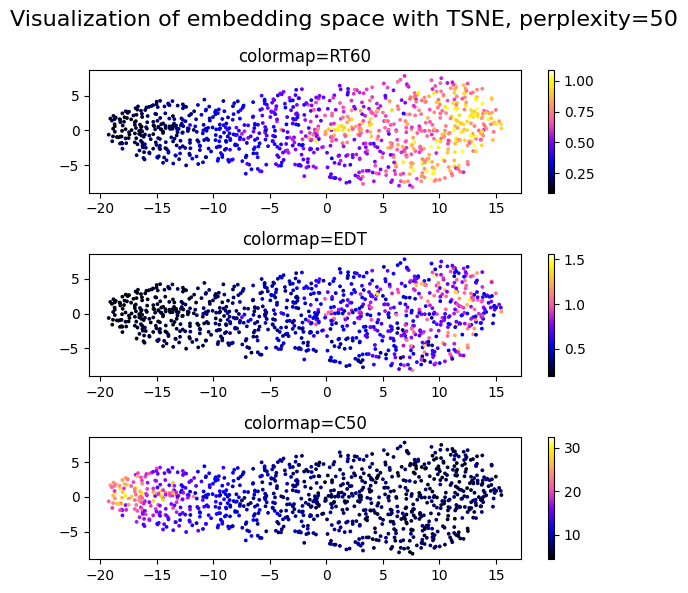

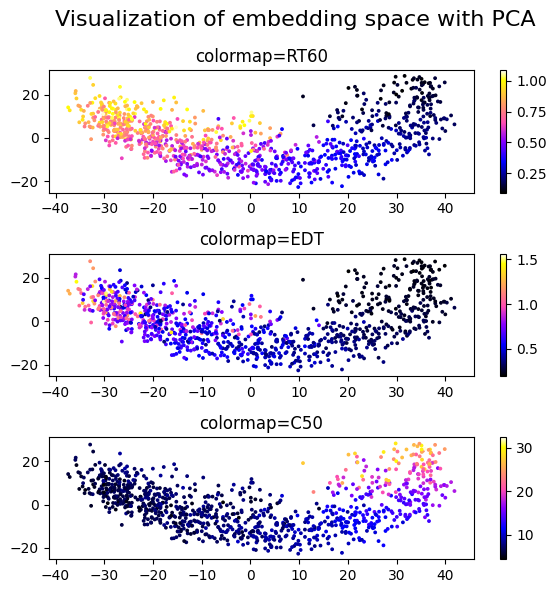

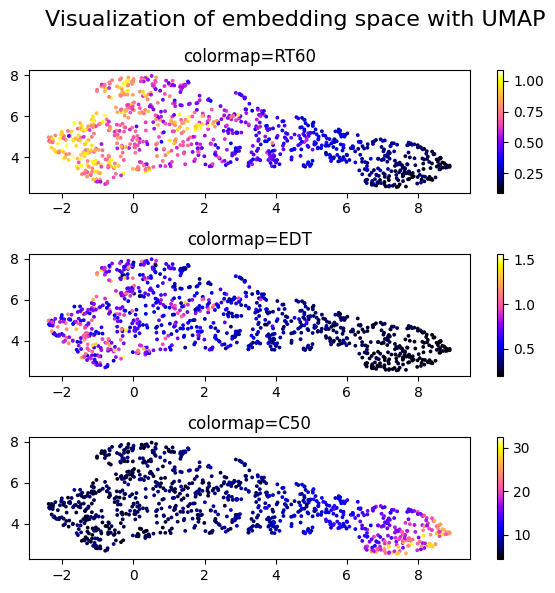

In [11]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

cmap = plt.get_cmap('gnuplot2')

# embeddings_tsne=embeddings_tsne[0:500,:]

plt.figure(figsize=(6,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.set_cmap(cmap)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.set_cmap(cmap)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.set_cmap(cmap)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.set_cmap(cmap)
plt.tight_layout()
plt.savefig('TSNE.pdf', format='pdf')
plt.show()


plt.figure(figsize=(6,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.tight_layout()
plt.savefig('PCA.pdf', format='pdf')
plt.show()



plt.figure(figsize=(6,6))
plt.suptitle('Visualization of embedding space with UMAP', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.tight_layout()
plt.savefig('UMAP.pdf', format='pdf')
plt.show()

In [ ]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS FROM THE SAME RIR ##################


from torch.utils.data import Subset



# Create a special data set containing style data with only one specific impulse response
N_audios=100
N_irs=5
emb_arr=np.zeros([N_audios*N_irs,512])
id_array=np.zeros([N_audios*N_irs,1])


# styleIR_indices=list(range(0, N_irs))

styleIR_indices= [0,1,11,3,12]

styleIR_indices=np.random.randint(10000, size=N_irs)

styleIR_indices=[6786, 9377, 2068, 0, 12]

for i,idx in enumerate(styleIR_indices):
    config["split"]="test"
    config["style_rir"]=dataset.get_info(idx)["ir_file_path"]
    print(config["style_rir"])
    dataset_this_ir=ds.DatasetReverbTransfer(config)
    # indices_audios=list(range(0,N_audios))
    indices_audios=list(np.random.randint(10000, size=N_audios))
    dataset_this_ir=Subset(dataset_this_ir,indices_audios)

    for j,data in enumerate(dataset_this_ir):
        # get style audio
        sStyle_in=data[1]
        # get style embedding of size 512
        with torch.no_grad():
            embedding=model.conditioning_network(sStyle_in.unsqueeze(0).to(config["device"]))
            emb_arr[(i*N_audios)+j,:]=embedding.cpu().numpy()
        id_array[(i*N_audios)+j]=i


/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1976y1427z258_rtms53.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x2247y1327z380_rtms74.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1435y806z411_rtms47.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x517y511z326_rtms21.wav
/home/ubuntu/Data/synth_rirs_mono/monoRIR_x1604y1259z278_rtms44.wav


In [112]:
styleIR_indices

[6786, 9377, 2068, 0, 12]

In [113]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# reduce dimensionality of the embeddings
# using pca:
embeddings_pca_rir=PCA(n_components=2).fit_transform(emb_arr)
# using first pca and then tsne:
# embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(PCA(n_components=50).fit_transform(emb_arr))
# using tsne:
embeddings_tsne_rir = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(emb_arr)

# using u-map:
embeddings_umap_rir = umap.UMAP(n_components=2).fit_transform(emb_arr)

In [114]:
a=id_array.astype(str).tolist()

id_array=id_array+1

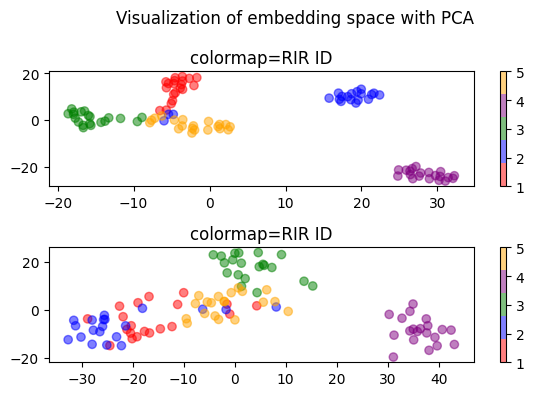

In [115]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# Define a colormap with 5 distinct colors
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['red', 'blue', 'green', 'purple', 'orange'])

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=12)
plt.scatter(embeddings_tsne_rir[:,0] , embeddings_tsne_rir[:,1], c=id_array, cmap=cmap,alpha=0.5);plt.colorbar();plt.title('colormap=RIR ID')
plt.subplot(2,1,2)
plt.suptitle('Visualization of embedding space with PCA', fontsize=12)
plt.scatter(embeddings_pca_rir[:,0] , embeddings_pca_rir[:,1], c=id_array, cmap=cmap, alpha=0.5);plt.colorbar();plt.title('colormap=RIR ID')
plt.tight_layout()
plt.savefig('lat2.pdf', format='pdf')
plt.show()

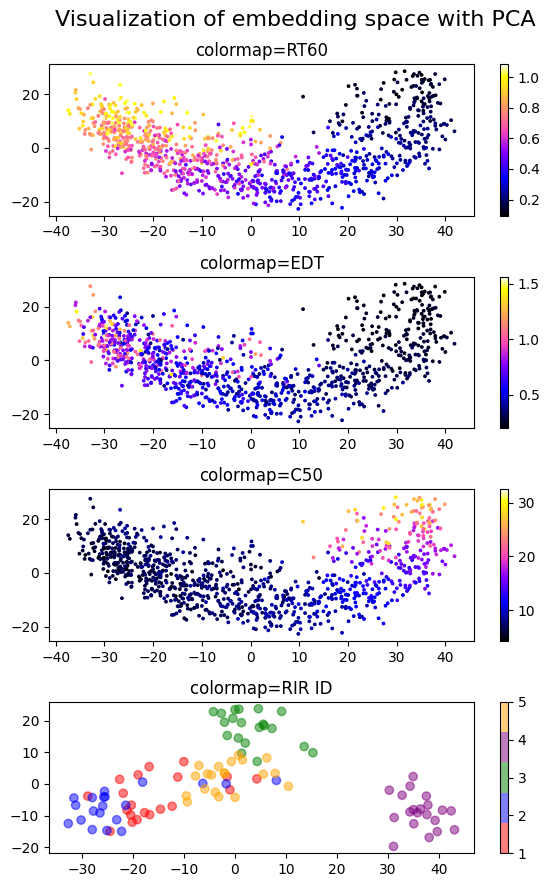

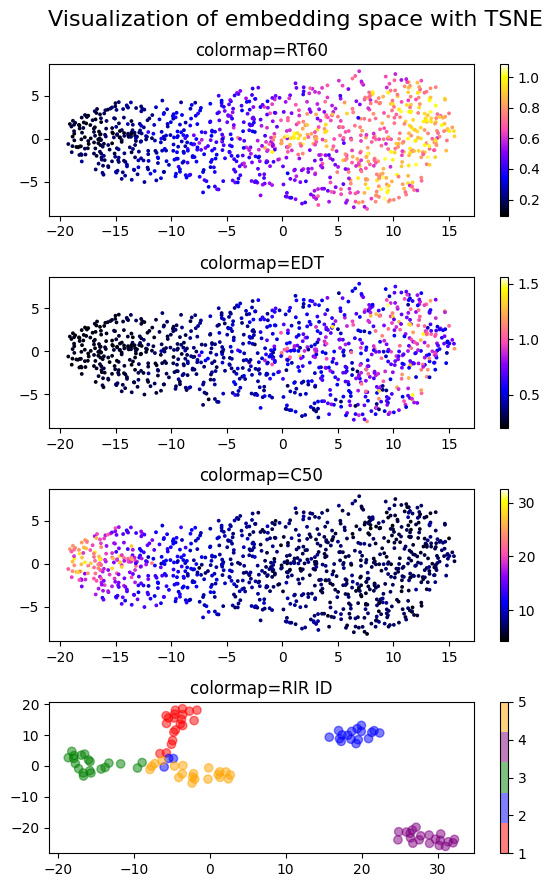

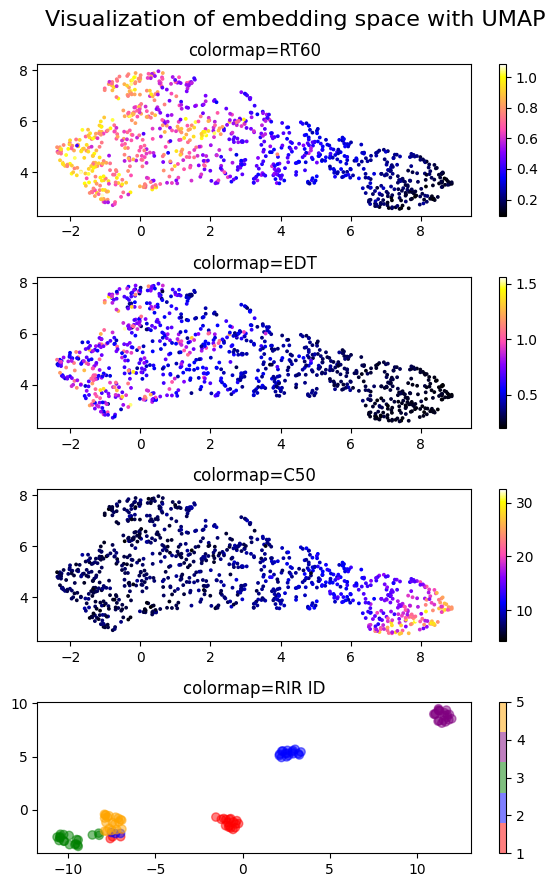

In [116]:
# Define a colormap with 5 distinct colors
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['red', 'blue', 'green', 'purple', 'orange'])

plt.figure(figsize=(6,9))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(4,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(4,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(4,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.subplot(4,1,4)
plt.scatter(embeddings_pca_rir[:,0] , embeddings_pca_rir[:,1], c=id_array, cmap=cmap, alpha=0.5);plt.colorbar();plt.title('colormap=RIR ID')
plt.tight_layout()
plt.savefig('pca.pdf', format='pdf')
plt.show()



plt.figure(figsize=(6,9))
plt.suptitle('Visualization of embedding space with TSNE', fontsize=16)
plt.subplot(4,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(4,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(4,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.subplot(4,1,4)
plt.scatter(embeddings_tsne_rir[:,0] , embeddings_tsne_rir[:,1], c=id_array, cmap=cmap, alpha=0.5);plt.colorbar();plt.title('colormap=RIR ID')
plt.tight_layout()
plt.savefig('tsne.pdf', format='pdf')
plt.show()


plt.figure(figsize=(6,9))
plt.suptitle('Visualization of embedding space with UMAP', fontsize=16)
plt.subplot(4,1,1)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=rt60_true_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(4,1,2)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=edt_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(4,1,3)
plt.scatter(embeddings_umap[:,0] , embeddings_umap[:,1], c=c50_meas_arr[indices_subset], s=3);plt.colorbar();plt.title('colormap=C50')
plt.subplot(4,1,4)
plt.scatter(embeddings_umap_rir[:,0] , embeddings_umap_rir[:,1], c=id_array, cmap=cmap, alpha=0.5);plt.colorbar();plt.title('colormap=RIR ID')
plt.tight_layout()
plt.savefig('umap.pdf', format='pdf')
plt.show()
